In [1]:
# Database used: https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data
# TODO Maybe we should not be using pictures of glaciers, mountains, etc., just one single type of image
#  (for now)

import os
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import numpy as np

In [2]:
train_image_paths = {'buildings': [],
           'forest': [],
           'glacier': [],
           'mountain': [],
           'sea': [],
           'street': []
          }
test_image_paths = {'buildings': [],
           'forest': [],
           'glacier': [],
           'mountain': [],
           'sea': [],
           'street': []
          }
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [3]:
DATASET_PATH = "../dataset"

In [4]:
def go_though_database(database_path):
    for path, subdirs, files in os.walk(database_path):
        for file in files:
            current_path = path
            # TODO [Vukan] : This will cause issues on Kacas device, ping her for it
            if 'seg_train\seg_train' in path:
                file_path = os.path.join(path, file)
                for category in categories:
                    if category in file_path:
                        train_image_paths[category].append(file_path)
            if 'seg_test\seg_test' in path:
                file_path = os.path.join(path, file)
                for category in categories:
                    if category in file_path:
                        test_image_paths[category].append(file_path)

In [5]:
go_though_database(DATASET_PATH)

In [6]:
def create_mask(image):
    img_height, img_width = image.shape[:2] #(150, 150, 3)
    mask = 255 * np.ones_like(image) # matrix of ones -> white image
    blackout_start_index = img_width // 3
    
    for i in range(img_height):
        for j in range(img_width):
            if j >= blackout_start_index and j < 2*blackout_start_index:
                mask[i, j] = 0

    return mask

In [7]:
# applys mask to the image 
def edit_image(image_path):
    image = cv2.imread(image_path)
    mask = create_mask(image)
    edited_image = cv2.bitwise_and(image, mask)
    return edited_image


In [8]:
def save_edited_images(image_paths, category, set_type):
    directory = f"../dataset/edited/{set_type}/{category}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    for index, image_path in enumerate(image_paths):
        image = edit_image(image_path)
        edited_image_name = image_path.split('\\')[-1].split('.')[0] + '_edited.jpg'
        edited_image_path = os.path.join(directory, edited_image_name)
        # (input_image_path, output_image_path)
        image_paths[index] = (edited_image_path, image_path)
        cv2.imwrite(edited_image_path, image)
        

In [9]:
for category in categories:
    save_edited_images(train_image_paths[category], category, "train")
    save_edited_images(test_image_paths[category], category, "test")

In [10]:
MAX_PIXEL_COLOR_VALUE = 255.0

In [11]:
@tf.function() # error because of jit_compile parameter
def load(input_image_path, output_image_path):
    input_image = tf.io.read_file(input_image_path)
    input_image = tf.io.decode_jpeg(input_image)
    input_image = tf.cast(input_image, tf.float32)
    output_image = tf.io.read_file(output_image_path)
    output_image = tf.io.decode_jpeg(output_image)
    # TODO [vukan] : Why is this needed? (Check with Kaca)
    output_image = tf.cast(output_image, tf.float32)
    return input_image, output_image

In [12]:
train_image_paths

{'buildings': [('../dataset/edited/train/buildings\\0_edited.jpg',
   '../dataset\\seg_train\\seg_train\\buildings\\0.jpg'),
  ('../dataset/edited/train/buildings\\10006_edited.jpg',
   '../dataset\\seg_train\\seg_train\\buildings\\10006.jpg'),
  ('../dataset/edited/train/buildings\\1001_edited.jpg',
   '../dataset\\seg_train\\seg_train\\buildings\\1001.jpg'),
  ('../dataset/edited/train/buildings\\10014_edited.jpg',
   '../dataset\\seg_train\\seg_train\\buildings\\10014.jpg'),
  ('../dataset/edited/train/buildings\\10018_edited.jpg',
   '../dataset\\seg_train\\seg_train\\buildings\\10018.jpg'),
  ('../dataset/edited/train/buildings\\10029_edited.jpg',
   '../dataset\\seg_train\\seg_train\\buildings\\10029.jpg'),
  ('../dataset/edited/train/buildings\\10032_edited.jpg',
   '../dataset\\seg_train\\seg_train\\buildings\\10032.jpg'),
  ('../dataset/edited/train/buildings\\10056_edited.jpg',
   '../dataset\\seg_train\\seg_train\\buildings\\10056.jpg'),
  ('../dataset/edited/train/buildings

In [13]:
def normalize_images(input_image, output_image) :
    input_image = (input_image / (MAX_PIXEL_COLOR_VALUE / 2)) - 1 
    output_image = (output_image / (MAX_PIXEL_COLOR_VALUE / 2)) - 1  
    return input_image, output_image

In [14]:
def resize_images(input_image, output_image, height, width): 
    input_image = tf.image.resize(input_image, [height, width])
    output_image = tf.image.resize(output_image, [height, width])
    return input_image, output_image

In [15]:
def crop_images(input_image, output_image, height, width):
    stacked_image = tf.stack([input_image, output_image], axis=0)
    cropped_image = tf.image.random_crop(
    stacked_image, size=[2, height, width, 3])
    return cropped_image[0], cropped_image[1]

In [16]:
def jitter_images(input_image, output_image, height, width, new_height, new_width):
    input_image, output_image = resize_images(input_image, output_image, new_height, new_width)
    input_image, output_image = crop_images(input_image, output_image, height, width)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        output_image = tf.image.flip_left_right(output_image)
    return input_image, output_image

In [17]:
# Resizing is a must, because our Generator takes in images with the shape of (256, 256, 3)

In [18]:
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256

In [19]:
LARGER_IMAGE_WIDTH = 286
LARGER_IMAGE_HEIGHT = 286

In [20]:
@tf.function() # error because of jit_compile parameter
def make_image_set(image_paths, is_training) :
    # lets firstly try out with only one category, and later try with all of them
    category = "street"
    images = []
    # TODO [vukan] : When testing on better device, remove the i check
    # for category in categories:
    for image_path_pair in image_paths[category]:
        input_image_path, output_image_path = image_path_pair
        input_image_path = input_image_path.replace("\\", "/")
        output_image_path = output_image_path.replace("\\", "/")
        input_image, output_image = load(input_image_path, output_image_path)
        if is_training:
            input_image, output_image = jitter_images(input_image, output_image, IMAGE_HEIGHT, IMAGE_WIDTH, LARGER_IMAGE_HEIGHT, LARGER_IMAGE_WIDTH)
        else:
            input_image, output_image = resize_images(input_image, output_image, IMAGE_HEIGHT, IMAGE_WIDTH)
        images.append(normalize_images(input_image, output_image))
    return images

In [21]:
train_images = make_image_set(train_image_paths, True)
test_images = make_image_set(test_image_paths, False)

In [22]:
input_image_path = '../dataset\\seg_train\\seg_train\\street\\1000.jpg'
input_image = tf.io.read_file(input_image_path)

In [23]:
input_image, output_image = train_images[0]

In [24]:
%run Generator.ipynb

Model: "gen"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 64  3392        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  131712      ['sequential[0][0]']             
                                                                                                

In [25]:
generator = Generator(input_image.shape)

In [26]:
%run Discriminator.ipynb

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 target_image (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_14 (Concatenate)   (None, 256, 256, 6)  0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']       

In [27]:
discriminator = Discriminator(input_image.shape)

In [28]:
def display_images(generator_model, input_image, output_image):
    generated_image = generator_model(input_image[tf.newaxis, ...], training=True)
    fig = plt.figure(figsize=(10, 7)) 
    rows = 1
    columns = 3
    fig.add_subplot(rows, columns, 1) 
    plt.imshow(input_image *  0.5 + 0.5)
    plt.title("Input") 
    fig.add_subplot(rows, columns, 2) 
    plt.imshow(output_image *  0.5 + 0.5)
    plt.title("Output")  
    fig.add_subplot(rows, columns, 3) 
    plt.imshow(generated_image[0] *  0.5 + 0.5)    
    plt.title("Generated") 

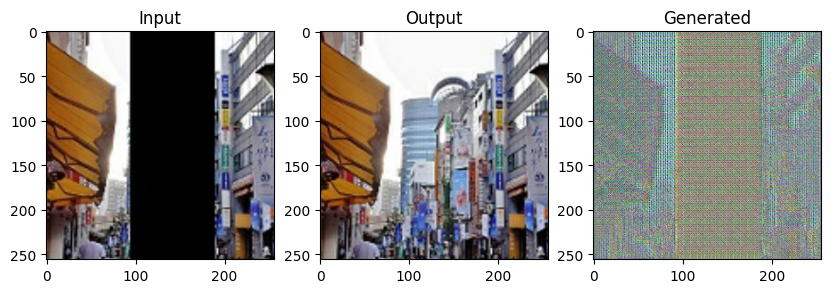

In [29]:
display_images(generator.model, input_image, output_image)

In [30]:
import datetime
import time

In [31]:
log_dir="../logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

checkpoint_dir = '../training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator.optimizer,
                                 discriminator_optimizer=discriminator.optimizer,
                                 generator=generator.model,
                                 discriminator=discriminator.model)

In [32]:
def train_step(input_image, output_image, generator, discriminator, step):
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        
        generator_model = generator.model
        discriminator_model = discriminator.model
        
        generated_image = generator_model(input_image[tf.newaxis, ...], training=True)
        discriminator_real_output = discriminator_model([input_image[tf.newaxis, ...], output_image[tf.newaxis, ...]], training=True)
        discriminator_generated_output = discriminator_model([input_image[tf.newaxis, ...], generated_image], training=True)
    
        generator_loss, cross_entropy_loss, l1_loss = generator.loss(discriminator_generated_output, generated_image, output_image)
        discriminator_loss = discriminator.loss(discriminator_real_output, discriminator_generated_output)
    
    generator_gradients = generator_tape.gradient(generator_loss, generator_model.trainable_variables)
    discriminator_gradients = discriminator_tape.gradient(discriminator_loss, discriminator_model.trainable_variables)
    
    generator.optimizer.apply_gradients(zip(generator_gradients, generator_model.trainable_variables))
    discriminator.optimizer.apply_gradients(zip(discriminator_gradients, discriminator_model.trainable_variables))
    
    with summary_writer.as_default():
        tf.summary.scalar('generator_loss', generator_loss, step=step // 1000)
        tf.summary.scalar('cross_entropy_loss', cross_entropy_loss, step=step // 1000)
        tf.summary.scalar('l1_loss', l1_loss, step=step // 1000)
        tf.summary.scalar('discriminator_loss', discriminator_loss, step=step // 1000)

In [33]:
def fit(train_images, test_images, generator, discriminator, steps):
    example_input, example_output = next(iter(test_images.take(1)))
    start = time.time()

    for step, (input_image, output_image) in train_images.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()
            
            display_images(generator.model, example_input, example_output)
            print(f"Step: {step//1000}k")

        train_step(input_image, output_image, generator, discriminator, step)
        
        if (step + 1) % 10 == 0:
            print('.', end='', flush=True)            

        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [34]:
train_dataset = tf.data.experimental.from_list(train_images)
test_dataset = tf.data.experimental.from_list(test_images)

Step: 0k
....................................................................................................Time taken for 1000 steps: 3132.29 sec

Step: 1k
....................................................................................................Time taken for 1000 steps: 3168.38 sec

Step: 2k
....................................................................................................Time taken for 1000 steps: 3139.48 sec

Step: 3k
....................................................................................................Time taken for 1000 steps: 3145.87 sec

Step: 4k
....................................................................................................Time taken for 1000 steps: 3139.38 sec

Step: 5k
....................................................................................................Time taken for 1000 steps: 3142.16 sec

Step: 6k
.................................................................................................

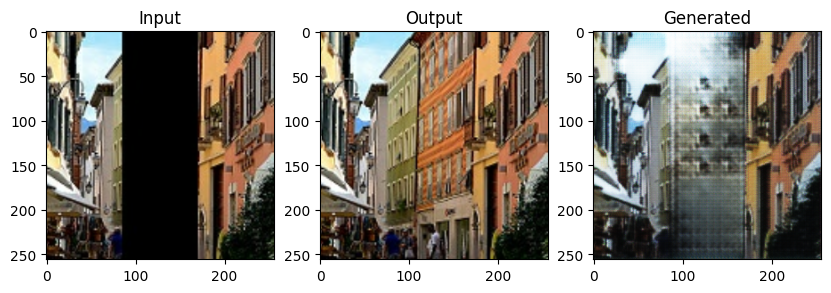

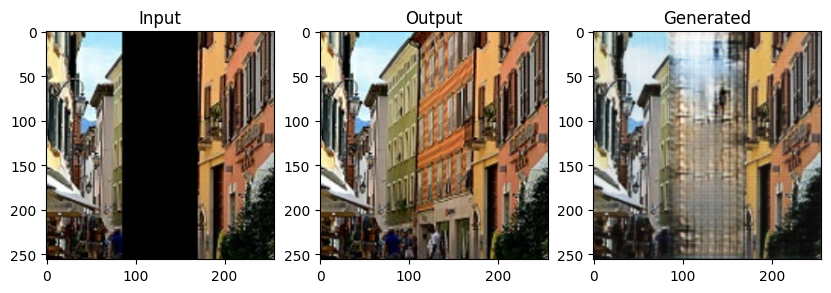

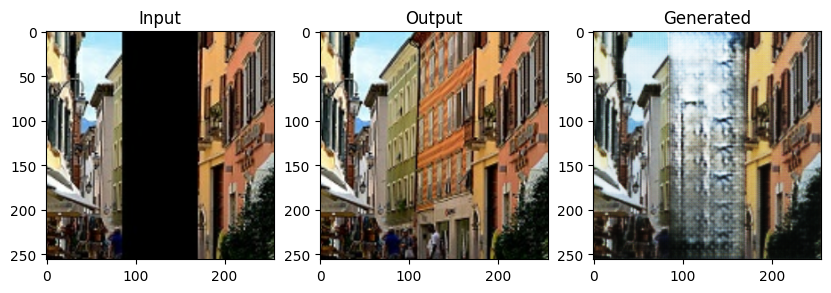

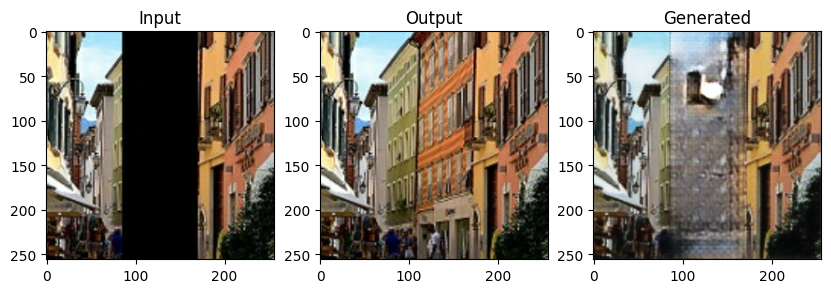

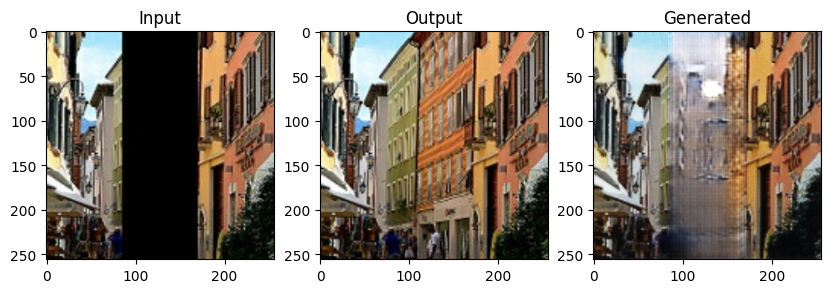

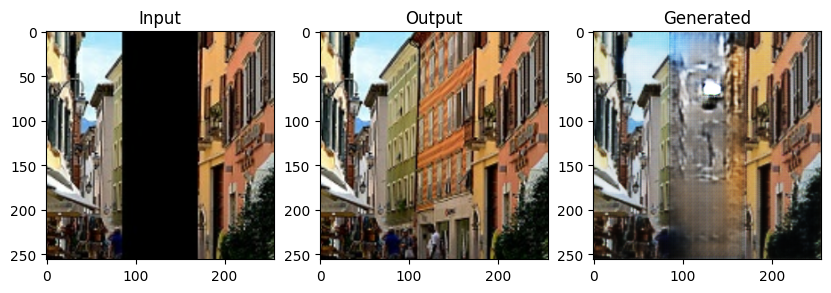

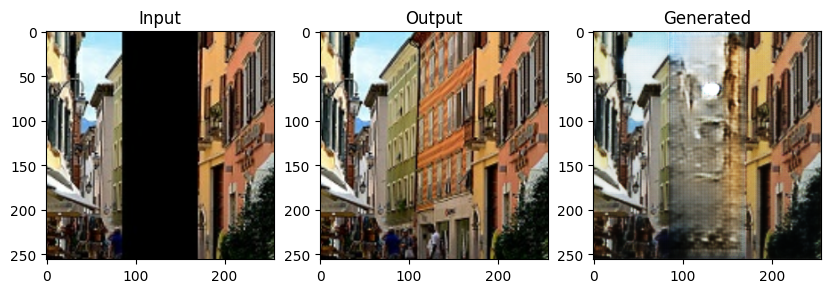

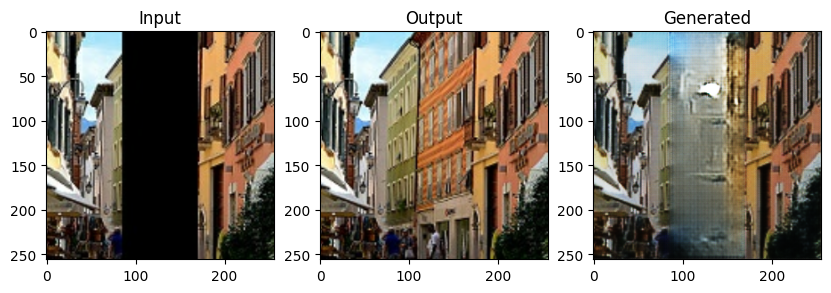

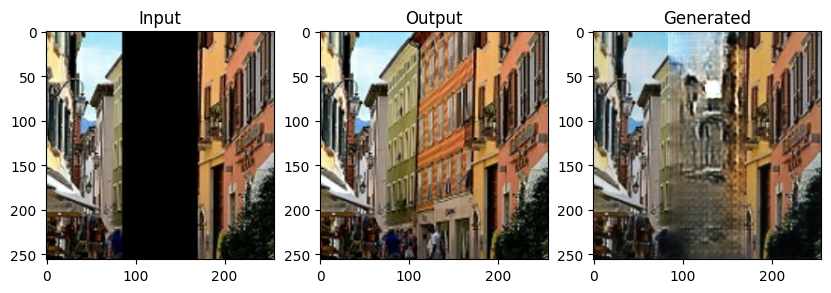

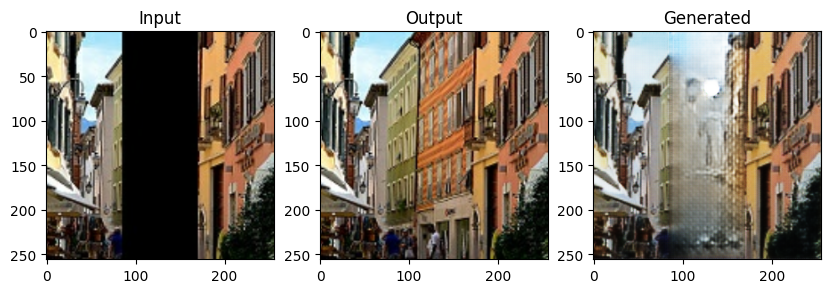

In [36]:
fit(train_dataset, test_dataset, generator, discriminator, steps=10000)

In [ ]:
display_images(generator.model, input_image, output_image)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
test_input_image, test_output_image = test_images[-15]
display_images(generator.model, test_input_image, test_output_image)

In [ ]:
import numpy as np
from tensorflow.python.keras import backend

try:
    arg_0_tensor = tf.saturate_cast(tf.random.uniform([], minval=0, maxval=2, dtype=tf.int64), dtype=tf.uint64)
    arg_0 = tf.identity(arg_0_tensor)
    arg_1 = -674
    arg_2 = tf.cast(arg_2, tf.uint64) 
    out = backend.clip(arg_0,arg_1,arg_2)
    print("e")
except Exception as e:
    print("Error:"+str(e))

In [ ]:
import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    for gpu in gpus:
        print(gpu)
else:
    print("nisam naso")

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [38]:
import tensorflow as tf
import numpy as np
from tensorflow.python.keras import backend

try:
    arg_0_tensor = tf.saturate_cast(tf.random.uniform([], minval=0, maxval=2, dtype=tf.int64), dtype=tf.uint64)
    arg_0 = tf.identity(arg_0_tensor)
    arg_1 = -674
    arg_2 = False
    out = backend.clip(arg_0,arg_1,arg_2)
except Exception as e:
    print("Error:"+str(e))

Error:{{function_node __wrapped__Minimum_device_/job:localhost/replica:0/task:0/device:GPU:0}} JIT compilation failed. [Op:Minimum]
